# Imports

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging 
import csv
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import *
from keras.wrappers.scikit_learn import KerasClassifier
import keras

import random
import math
from sklearn import tree, preprocessing
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.ensemble import AdaBoostClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, CSVLogger
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import FastICA, PCA
from scipy.stats import kurtosis, skew
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection

import timeit

#from imblearn.over_sampling import RandomOverSampler

# Functions

In [11]:
def MAPE(pred,act):
    return np.mean(np.abs(pred-act)/act)*100

def Pred_correct(pred,act):
    correct = np.abs(pred-act)
    return len(correct[correct==0])/len(act)

def convert_out(data):
    output = []
    for i in range(np.shape(data)[0]):
        loc = np.where(data[i,]==max(data[i,]))[0]
        output.append(loc[0]+1)
    return(output)

def create_model_nn(neurons=1,optimizer='adam'):
# create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=14, kernel_initializer='normal', activation='relu'))
    model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def create_model_tree():
    dtree = tree.DecisionTreeClassifier(criterion = "entropy", splitter = 'best', max_leaf_nodes = 90, min_samples_leaf = 1, max_depth=3)

    

# Preprocessing data

In [12]:
data = pd.read_csv('leaf.csv', header=None)
data.drop([1],inplace=True,axis=1)
X = data.values[:,1:]
Y_first = data.values[:,0]
Y = []
out = np.zeros(shape=[36])
for i in range(np.shape(Y_first)[0]):
    out[int(Y_first[i])-1]=1
    Y.append(out)
    out = np.zeros(shape=[36])
Y = np.array(Y)
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
df_normalized = pd.DataFrame(X_scaled)

r,c = np.shape(df_normalized)

total_samples = list(np.arange(0,r,1))
test_samples = random.sample(total_samples,int(np.round(len(total_samples)*0.2)))
train_samples = list(set(total_samples) - set(test_samples))

# Splitting data

In [13]:
trainX = X[train_samples]
trainY = Y[train_samples]
trainY_comp = Y_first[train_samples]
trainX_scaled = X_scaled[train_samples]

testX = X[test_samples]
testY = Y[test_samples]
testY_comp = Y_first[test_samples]
testX_scaled = X_scaled[train_samples]


# KMeans

In [14]:
unique_Y = (list(set(Y_first)))


kmeans = KMeans(n_clusters=len(unique_Y),random_state=1).fit(trainX_scaled)
new_labels = kmeans.labels_

c_size = np.zeros((2,len(unique_Y)))
for i in range(len(unique_Y)):
    idx = np.where(Y_first==unique_Y[i])[0]
    c_size[0,i] = len(Y_first[Y_first==unique_Y[i]])
    new_clusters = new_labels[idx]
    unique_list = (list(set(new_clusters)))
    nc_occ = [len(np.where(new_clusters==unique_list[k])[0]) for k in range(len(unique_list))]
    max_num = unique_list[np.where(nc_occ==np.max(nc_occ))[0][0]]
    c_size[1,i] = len(np.where(new_clusters==max_num)[0])
print(c_size)
print(np.sum(c_size,1))
avg = c_size[1,:]/c_size[0,:]
np.mean(avg)

IndexError: index 272 is out of bounds for axis 1 with size 272

# K means elbow method

No handles with labels found to put in legend.


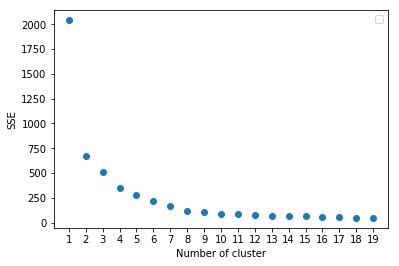

In [15]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k,random_state=1).fit(trainX)
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'o')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.xticks(list(sse.keys()))
plt.legend()
plt.show()

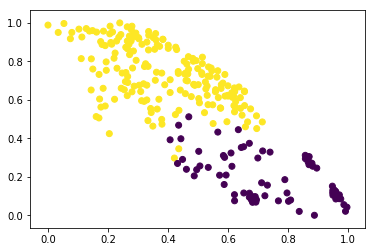

In [16]:
kmeans = KMeans(n_clusters=2,random_state=1).fit(trainX_scaled)
labels =  kmeans.predict(trainX_scaled)
res=kmeans.__dict__
plt.scatter(trainX_scaled[:, 2], trainX_scaled[:, 5], c=labels,
             cmap='viridis');



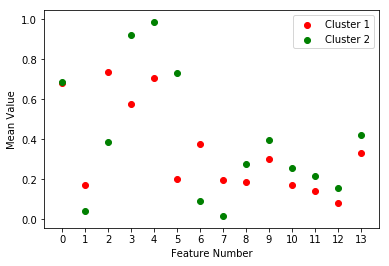

In [17]:
xplot = np.zeros((2,14))
xplot[:,:] = np.arange(0,14,1)
c=['red','green','blue']
l=['Cluster 1', 'Cluster 2', 'Cluster 3']
for i in range(np.shape(res['cluster_centers_'])[0]):
    plt.scatter(xplot[i,:],np.transpose(res['cluster_centers_'][i,:]),color = c[i],label=l[i])
    
plt.xticks(np.arange(0,14,1))
plt.xlabel('Feature Number')
plt.ylabel('Mean Value')
plt.legend()
plt.show()

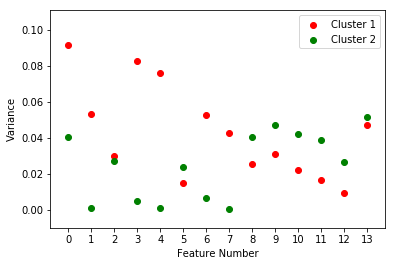

In [18]:
idx_zero = np.where(kmeans.labels_==0)
zeros_array = trainX_scaled[idx_zero]
vars_zero = np.var(zeros_array,axis=0)
idx_ones = np.where(kmeans.labels_==1)
ones_array = trainX_scaled[idx_ones]
vars_ones = np.var(ones_array,axis=0)
c=['red','green','blue']
l=['Cluster 1', 'Cluster 2', 'Cluster 3']


plt.scatter(xplot[0,:],np.reshape(vars_zero,[1,-1]),color = c[0],label=l[0])
plt.scatter(xplot[1,:],np.transpose(vars_ones),color = c[1],label=l[1])

plt.xticks(np.arange(0,14,1))
plt.xlabel('Feature Number')
plt.ylabel('Variance')
plt.legend()
plt.show()

# K Means Silhouette

In [19]:
for n_cluster in range(2, 20):
    kmeans = KMeans(n_clusters=n_cluster,random_state=1).fit(trainX)
    label = kmeans.labels_
    sil_coeff = silhouette_score(trainX, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.7756632333185297
For n_clusters=3, The Silhouette Coefficient is 0.5710259005784233
For n_clusters=4, The Silhouette Coefficient is 0.5820506990095486
For n_clusters=5, The Silhouette Coefficient is 0.591850836877975
For n_clusters=6, The Silhouette Coefficient is 0.3585034199094298
For n_clusters=7, The Silhouette Coefficient is 0.37670673827495177
For n_clusters=8, The Silhouette Coefficient is 0.40051443935825354
For n_clusters=9, The Silhouette Coefficient is 0.3830341295519247
For n_clusters=10, The Silhouette Coefficient is 0.37778312506878725
For n_clusters=11, The Silhouette Coefficient is 0.3666189586693501
For n_clusters=12, The Silhouette Coefficient is 0.37630152632511465
For n_clusters=13, The Silhouette Coefficient is 0.3640203038102311
For n_clusters=14, The Silhouette Coefficient is 0.33292207825452147
For n_clusters=15, The Silhouette Coefficient is 0.33686063564248175
For n_clusters=16, The Silhouette Coefficient is 0.

# EM

In [20]:
gmm = GaussianMixture(n_components=len(unique_Y),random_state=1)
gmm.fit(X)
new_labels = gmm.predict(X)+1
c_size = np.zeros((2,len(unique_Y)))
for i in range(len(unique_Y)):
    idx = np.where(Y_first==unique_Y[i])[0]
    c_size[0,i] = len(Y_first[Y_first==unique_Y[i]])
    new_clusters = new_labels[idx]
    unique_list = (list(set(new_clusters)))
    nc_occ = [len(np.where(new_clusters==unique_list[k])[0]) for k in range(len(unique_list))]
    max_num = unique_list[np.where(nc_occ==np.max(nc_occ))[0][0]]
    c_size[1,i] = len(np.where(new_clusters==max_num)[0])
print(c_size)
print(np.sum(c_size,1))
avg = c_size[1,:]/c_size[0,:]
np.mean(avg)

[[ 12.  10.  10.   8.  12.   8.  10.  11.  14.  13.  16.  12.  13.  12.
   10.  12.  11.  13.   9.  12.  11.  12.  12.  12.  11.  11.  11.  11.
   11.  10.]
 [  7.   4.   6.   4.  11.   5.   4.  11.   6.   7.   9.   6.   6.   7.
    8.   5.   5.   4.   9.   3.   5.   4.  12.   5.   3.   6.   5.   7.
    8.   6.]]
[ 340.  188.]


0.55897394272394285

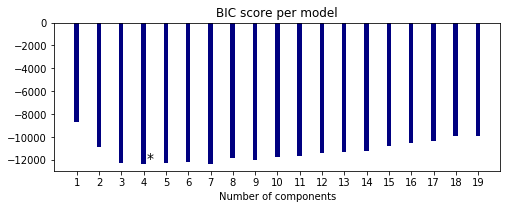

In [21]:
lowest_bic = np.infty

bic = []
n_components_range = range(1, 20)
cv_types = ['full']
#cv_types = ['spherical', 'tied', 'diag','full']

for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=n_components,random_state=4)
    gmm.fit(trainX_scaled)
    bic.append(gmm.bic(trainX_scaled))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 0.05)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))

plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos+0.5, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
#spl.legend([b[0] for b in bars], cv_types)

Y_ = clf.predict(trainX)
# # Plot the winner
# splot = plt.subplot(2, 1, 2)
# Y_ = clf.predict(trainX)

# for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
#                                            color_iter)):
#     v, w = linalg.eigh(cov)
#     if not np.any(Y_ == i):
#         continue
#     plt.scatter(X[Y_ == i, 5], X[Y_ == i, 6], .8, color=color)

#     # Plot an ellipse to show the Gaussian component
#     angle = np.arctan2(w[0][1], w[0][0])
#     angle = 180. * angle / np.pi  # convert to degrees
#     v = 2. * np.sqrt(2.) * np.sqrt(v)
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
#     ell.set_clip_box(splot.bbox)
#     ell.set_alpha(.5)
#     splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
# plt.title('Selected GMM: full model, 2 components')
# plt.subplots_adjust(hspace=.35, bottom=.02)
# plt.show()

4
14


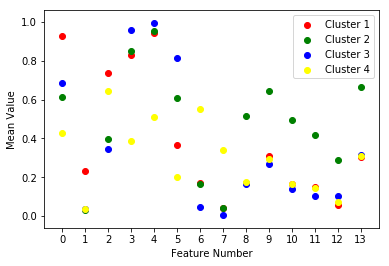

In [22]:
r,c = np.shape(clf.means_)
print(r)
print(c)
xplot = np.zeros((r,14))
xplot[:,:] = np.arange(0,14,1)
c=['red','green','blue','yellow','purple']
l=['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4', 'Cluster 5']
for i in range(r):
    plt.scatter(xplot[i,:],np.transpose(clf.means_[i,:]),color = c[i],label=l[i])
    
plt.xticks(np.arange(0,14,1))
plt.xlabel('Feature Number')
plt.ylabel('Mean Value')
plt.legend()
plt.show()



4 14 14


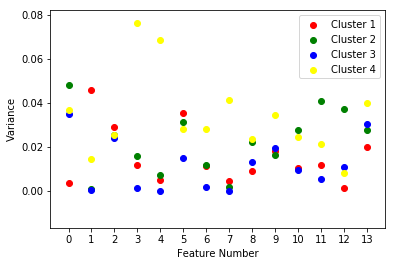

In [23]:
r,c,n = np.shape(clf.covariances_)
print(r,c,n)
xplot = np.zeros((r,14))
xplot[:,:] = np.arange(0,14,1)
c=['red','green','blue','yellow','purple']
l=['Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4', 'Cluster 5']
for i in range(r):
    vals = np.diagonal((clf.covariances_[i,:,:]))
    plt.scatter(xplot[i,:],np.transpose(vals),color = c[i],label=l[i])
    
plt.xticks(np.arange(0,14,1))
plt.xlabel('Feature Number')
plt.ylabel('Variance')
plt.legend()
plt.show()

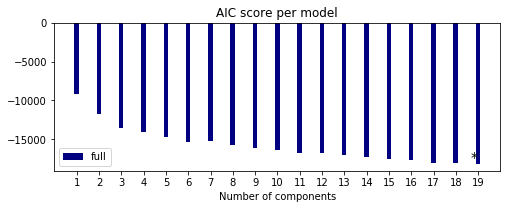

In [24]:
lowest_aic = np.infty

aic = []
n_components_range = range(1, 20)
cv_types = ['full']

for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type,random_state=1)
        gmm.fit(trainX_scaled)
        aic.append(gmm.aic(trainX_scaled))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm
            

aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the AIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 0.05)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
#plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('AIC score per model')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.97 + .03 * aic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)


# # Plot the winner
# splot = plt.subplot(2, 1, 2)
# Y_ = clf.predict(X)
# for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
#                                            color_iter)):
#     v, w = linalg.eigh(cov)
#     if not np.any(Y_ == i):
#         continue
#     plt.scatter(X[Y_ == i, 2], X[Y_ == i, 6], .8, color=color)

#     # Plot an ellipse to show the Gaussian component
#     angle = np.arctan2(w[0][1], w[0][0])
#     angle = 180. * angle / np.pi  # convert to degrees
#     v = 2. * np.sqrt(2.) * np.sqrt(v)
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
#     ell.set_clip_box(splot.bbox)
#     ell.set_alpha(.5)
#     splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
# plt.title('Selected GMM: full model, 2 components')
# plt.subplots_adjust(hspace=.35, bottom=.02)
# plt.show()

# ICA

In [102]:

# Compute ICA

# ica = FastICA(n_components=11)
# S_ = ica.fit_transform(trainX_scaled)  # Reconstruct signals
# A_ = ica.mixing_  # Get estimated mixing matrix

# print(kurtosis(S_,axis=0))
scalar = StandardScaler()
trainX_S = scalar.fit_transform(trainX)
testX_S = scalar.transform(testX)

ica = FastICA(random_state=1)
comp_to_check = 14
kurt_sp = np.zeros((comp_to_check,3))

train_all = []
test_all = []
train_acc_ica = []
val_acc_ica = []
test_acc_ica = []


for i in range(1,comp_to_check+1):
    print(i)
    ica.set_params(n_components=i)
    S_ = ica.fit_transform(trainX_S)
    proj = ica.inverse_transform(S_)
    loss_all = ((trainX_S - proj)**2).mean()
    kurt_sp[i-2,:] = np.array([i,np.mean(np.abs(kurtosis(S_,axis=0))),loss_all])
    
    trainX_transformed = ica.transform(trainX_S)
    testX_transformed = ica.transform(testX_S)
    
    trainX_S_use = trainX_transformed[:,:i]
    testX_S_use = testX_transformed[:,:i]
    
    trainX_use = trainX_S_use[values,:]
    trainY_use = trainY[values,:]
    trainY_comp_use = trainY_comp[values]

    

    model = Sequential()
    model.add(Dense(250, input_dim=i, kernel_initializer='normal', activation='relu'))
    model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # checkpoint
    filepath="weights.best_leaf.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, TestCallback((testX_S_use,testY)),CSVLogger('1.log')]
    hist = model.fit(trainX_use[:-82,:],trainY_use[:-82,:], validation_data=(trainX_use[-82:,:],trainY_use[-82:,:]), nb_epoch=2500, batch_size=40,verbose=0,callbacks=callbacks_list)
    
    model1 = Sequential()
    model1.add(Dense(250, input_dim=i, kernel_initializer='normal', activation='relu'))
    model1.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model1.load_weights("weights.best_leaf.h5")


    train_pred = convert_out(model1.predict(trainX_use[:-82,:]))
    train_act = trainY_comp_use[:-82]
    train_acc_ica.append((1-Pred_correct(train_pred,train_act)))

    val_pred = convert_out(model1.predict(trainX_use[-82:,:]))
    val_act = trainY_comp_use[-82:]
    val_acc_ica.append((1-Pred_correct(val_pred,val_act)))

    test_pred = convert_out(model1.predict(testX_S_use))
    test_acc_ica.append((1-Pred_correct(test_pred,testY_comp)))
 



1


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


2


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


3


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


4


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


5


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


6


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


7


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


8


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


9


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


10


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


11


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


12


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


13


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


14


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:52: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


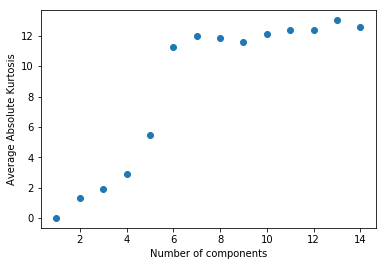

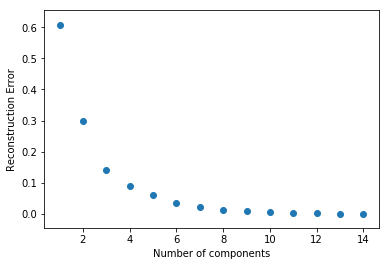

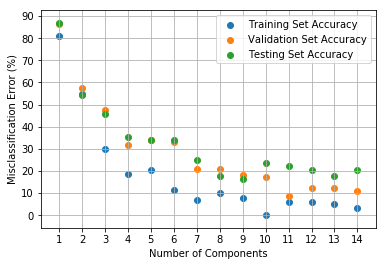

    Training Set  Validation Set  Testing Set
0      81.052632       86.585366    86.764706
1      54.736842       57.317073    54.411765
2      30.000000       47.560976    45.588235
3      18.421053       31.707317    35.294118
4      20.526316       34.146341    33.823529
5      11.578947       32.926829    33.823529
6       6.842105       20.731707    25.000000
7      10.000000       20.731707    17.647059
8       7.894737       18.292683    16.176471
9       0.000000       17.073171    23.529412
10      5.789474        8.536585    22.058824
11      5.789474       12.195122    20.588235
12      5.263158       12.195122    17.647059
13      3.157895       10.975610    20.588235


In [103]:
plt.scatter(kurt_sp[:,0],kurt_sp[:,1])
plt.xlabel('Number of components')
plt.ylabel('Average Absolute Kurtosis')
plt.show()


plt.scatter(kurt_sp[:,0],kurt_sp[:,2])
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error')
plt.show()

fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 100, 10))
ax.set_xticks(np.arange(1,len(train_acc_ica)+1))

plt.scatter(np.arange(1,len(train_acc_ica)+1),np.array(train_acc_ica)*100,label='Training Set Accuracy')
plt.scatter(np.arange(1,len(train_acc_ica)+1),np.array(val_acc_ica)*100,label='Validation Set Accuracy')
plt.scatter(np.arange(1,len(train_acc_ica)+1),np.array(test_acc_ica)*100,label='Testing Set Accuracy')
plt.xlabel('Number of Components')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.grid(True)
plt.show()

results = pd.DataFrame(data = np.transpose([np.array(train_acc_ica)*100,np.array(val_acc_ica)*100,np.array(test_acc_ica)*100]),columns=['Training Set', 'Validation Set', 'Testing Set'])
print(results)

# K Means

For n_clusters=2, The Silhouette Coefficient is 0.25564296257530356
For n_clusters=3, The Silhouette Coefficient is 0.1415655772206138
For n_clusters=4, The Silhouette Coefficient is 0.1768055991269605
For n_clusters=5, The Silhouette Coefficient is 0.1292072244055944
For n_clusters=6, The Silhouette Coefficient is 0.11984848919709018
For n_clusters=7, The Silhouette Coefficient is 0.13702158735097877
For n_clusters=8, The Silhouette Coefficient is 0.13986522614701744
For n_clusters=9, The Silhouette Coefficient is 0.151098697300292
For n_clusters=10, The Silhouette Coefficient is 0.16619116828396693
For n_clusters=11, The Silhouette Coefficient is 0.17330342846251204
For n_clusters=12, The Silhouette Coefficient is 0.18859239416814613
For n_clusters=13, The Silhouette Coefficient is 0.19636586942679177
For n_clusters=14, The Silhouette Coefficient is 0.20480142859680275
For n_clusters=15, The Silhouette Coefficient is 0.20702708786618243
For n_clusters=16, The Silhouette Coefficient i

No handles with labels found to put in legend.


For n_clusters=17, The Silhouette Coefficient is 0.2154490758160468
For n_clusters=18, The Silhouette Coefficient is 0.20761459963851875
For n_clusters=19, The Silhouette Coefficient is 0.22624869932485406


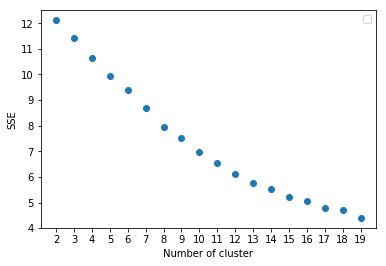

In [131]:
sse = {}

ica.set_params(n_components=13)
S_ = ica.fit_transform(trainX_S)
proj = ica.inverse_transform(S_)
trainX_transformed = ica.transform(trainX_S)
testX_transformed = ica.transform(testX_S)

trainX_S_use = trainX_transformed[:,:i]
testX_S_use = testX_transformed[:,:i]

trainX_use = trainX_S_use[values,:]
trainY_use = trainY[values,:]
trainY_comp_use = trainY_comp[values]

sse = {}
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k,random_state=1).fit(trainX_use)
    #print(data["clusters"])
    label = kmeans.labels_
    sil_coeff = silhouette_score(trainX_use, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(k, sil_coeff))
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'o')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.xticks(list(sse.keys()))
plt.legend()
plt.show()
    

# K Means + ICA + NN

In [184]:
l_use = 2
km = KMeans(n_clusters=l_use,random_state=2)
km.fit(trainX_use)
# print(km.labels_)
# plt.hist(km.labels_,l_use)
# plt.show()
lab_tr = km.predict(trainX_use)
lab_te = km.predict(testX_S_use)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(lab_tr.reshape(-1, 1))
lab_train=enc.transform(lab_tr.reshape(-1, 1)).toarray()
lab_test = enc.transform(lab_te.reshape(-1, 1)).toarray()

r,c = np.shape(trainX_use)
trainX_use_n = np.hstack((trainX_use,lab_train))
testX_use_n = np.hstack((testX_S_use,lab_test))

model = Sequential()
model.add(Dense(250, input_dim=c+l_use, kernel_initializer='normal', activation='relu'))
model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint

train_acc_ica_f = []
val_acc_ica_f = []
test_acc_ica_f = []


filepath="weights.best_leaf.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint, TestCallback((testX_use_n,testY)),CSVLogger('1.log')]
hist = model.fit(trainX_use_n[:-82,:],trainY_use[:-82,:], validation_data=(trainX_use_n[-82:,:],trainY_use[-82:,:]), nb_epoch=2500, batch_size=40,verbose=0,callbacks=callbacks_list)

model1 = Sequential()
model1.add(Dense(250, input_dim=c+l_use, kernel_initializer='normal', activation='relu'))
model1.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.load_weights("weights.best_leaf.h5")


train_pred = convert_out(model1.predict(trainX_use_n[:-82,:]))
train_act = trainY_comp_use[:-82]
train_acc_ica_f.append((1-Pred_correct(train_pred,train_act)))

val_pred = convert_out(model1.predict(trainX_use_n[-82:,:]))
val_act = trainY_comp_use[-82:]
val_acc_ica_f.append((1-Pred_correct(val_pred,val_act)))

test_pred = convert_out(model1.predict(testX_use_n))
test_acc_ica_f.append((1-Pred_correct(test_pred,testY_comp)))

print(np.array(train_acc_ica_f)*100,np.array(val_acc_ica_f)*100,np.array(test_acc_ica_f)*100)

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


# EM + ICA + NN

Text(0.5,0,'Number of components')

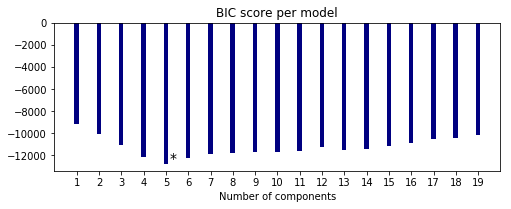

In [187]:
lowest_bic = np.infty

bic = []
n_components_range = range(1, 20)
cv_types = ['full']
#cv_types = ['spherical', 'tied', 'diag','full']

for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components=n_components,random_state=4)
    gmm.fit(trainX_use)
    bic.append(gmm.bic(trainX_use))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 0.05)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))

plt.xticks(n_components_range)
#plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos+0.5, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
#spl.legend([b[0] for b in bars], cv_types)

# # Plot the winner
# splot = plt.subplot(2, 1, 2)
# Y_ = clf.predict(trainX)

# for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
#                                            color_iter)):
#     v, w = linalg.eigh(cov)
#     if not np.any(Y_ == i):
#         continue
#     plt.scatter(X[Y_ == i, 5], X[Y_ == i, 6], .8, color=color)

#     # Plot an ellipse to show the Gaussian component
#     angle = np.arctan2(w[0][1], w[0][0])
#     angle = 180. * angle / np.pi  # convert to degrees
#     v = 2. * np.sqrt(2.) * np.sqrt(v)
#     ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
#     ell.set_clip_box(splot.bbox)
#     ell.set_alpha(.5)
#     splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
# plt.title('Selected GMM: full model, 2 components')
# plt.subplots_adjust(hspace=.35, bottom=.02)
# plt.show()

In [193]:
l_use = 5

gmm = GaussianMixture(n_components=l_use,random_state=1)
gmm.fit(trainX_use)
tr_lab = gmm.predict(trainX_use)
test_lab = gmm.predict(testX_S_use)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(tr_lab.reshape(-1, 1))
lab_train=enc.transform(tr_lab.reshape(-1, 1)).toarray()
lab_test = enc.transform(test_lab.reshape(-1, 1)).toarray()

r,c = np.shape(trainX_use)
trainX_use_n = np.hstack((trainX_use,lab_train))
testX_use_n = np.hstack((testX_S_use,lab_test))

model = Sequential()
model.add(Dense(250, input_dim=c+l_use, kernel_initializer='normal', activation='relu'))
model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint

train_acc_ica_f_2 = []
val_acc_ica_f_2 = []
test_acc_ica_f_2 = []

filepath="weights.best_leaf.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint, TestCallback((testX_use_n,testY)),CSVLogger('1.log')]
hist = model.fit(trainX_use_n[:-82,:],trainY_use[:-82,:], validation_data=(trainX_use_n[-82:,:],trainY_use[-82:,:]), nb_epoch=2500, batch_size=40,verbose=0,callbacks=callbacks_list)

model1 = Sequential()
model1.add(Dense(250, input_dim=c+l_use, kernel_initializer='normal', activation='relu'))
model1.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.load_weights("weights.best_leaf.h5")


train_pred = convert_out(model1.predict(trainX_use_n[:-82,:]))
train_act = trainY_comp_use[:-82]
train_acc_ica_f_2.append((1-Pred_correct(train_pred,train_act)))

val_pred = convert_out(model1.predict(trainX_use_n[-82:,:]))
val_act = trainY_comp_use[-82:]
val_acc_ica_f_2.append((1-Pred_correct(val_pred,val_act)))

test_pred = convert_out(model1.predict(testX_use_n))
test_acc_ica_f_2.append((1-Pred_correct(test_pred,testY_comp)))

print(np.array(train_acc_ica_f_2)*100,np.array(val_acc_ica_f_2)*100,np.array(test_acc_ica_f_2)*100)

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


[ 2.10526316] [ 18.29268293] [ 27.94117647]


# PCA

1     0.390744
2     0.702312
3     0.858042
4     0.911453
5     0.940156
6     0.966665
7     0.979260
8     0.987713
9     0.992923
10    0.996102
11    0.997912
12    0.999179
13    0.999984
14    1.000000
dtype: float64


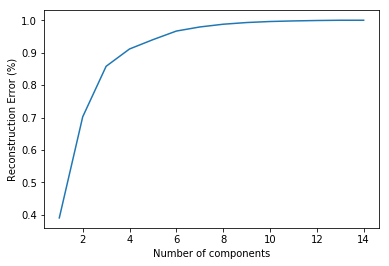

In [26]:
# Compute ICA

# ica = FastICA(n_components=11)
# S_ = ica.fit_transform(trainX_scaled)  # Reconstruct signals
# A_ = ica.mixing_  # Get estimated mixing matrix

# print(kurtosis(S_,axis=0))
n_comp = 14
pca = PCA(n_components=n_comp,random_state=1)
trainX_transformed = pca.fit_transform(trainX_S)
testX_transformed = pca.transform(testX_S)

tmp = pd.Series(data = pca.explained_variance_ratio_ ,index = range(1,n_comp+1))
tmp2 = pd.Series(data = pca.explained_variance_ ,index = range(1,n_comp+1))


mat = np.cumsum(tmp2)/np.sum(tmp2)
print(mat)
plt.plot(np.cumsum(tmp2)/np.sum(tmp2))
plt.xlabel('Number of components')
plt.ylabel('Reconstruction Error (%)')
plt.show()



# PCA + NN

In [70]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        logs['test_acc'] = acc
        
values = random.sample(list(np.arange(0,len(trainX_S),1)),len(trainX_S))


train_all = []
test_all = []
train_acc = []
val_acc = []
test_acc = []

for i in range(1,15):
    print(i)
    trainX_S_use = trainX_transformed[:,:i]
    testX_S_use = testX_transformed[:,:i]
    
    trainX_use = trainX_S_use[values,:]
    trainY_use = trainY[values,:]
    trainY_comp_use = trainY_comp[values]

    

    model = Sequential()
    model.add(Dense(250, input_dim=i, kernel_initializer='normal', activation='relu'))
    model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # checkpoint
    filepath="weights.best_leaf.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, TestCallback((testX_S_use,testY)),CSVLogger('1.log')]
    hist = model.fit(trainX_use[:-82,:],trainY_use[:-82,:], validation_data=(trainX_use[-82:,:],trainY_use[-82:,:]), nb_epoch=2500, batch_size=40,verbose=0,callbacks=callbacks_list)
    
    model1 = Sequential()
    model1.add(Dense(250, input_dim=i, kernel_initializer='normal', activation='relu'))
    model1.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model1.load_weights("weights.best_leaf.h5")


    train_pred = convert_out(model1.predict(trainX_use[:-82,:]))
    train_act = trainY_comp_use[:-82]
    train_acc.append((1-Pred_correct(train_pred,train_act)))

    val_pred = convert_out(model1.predict(trainX_use[-82:,:]))
    val_act = trainY_comp_use[-82:]
    val_acc.append((1-Pred_correct(val_pred,val_act)))

    test_pred = convert_out(model1.predict(testX_S_use))
    test_acc.append((1-Pred_correct(test_pred,testY_comp)))


1


C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:37: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


2
3
4
5
6
7
8
9
10
11
12
13
14


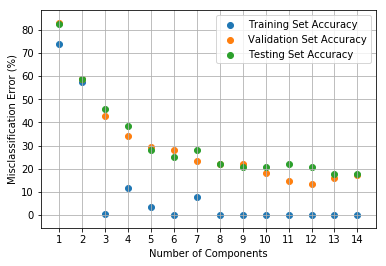

            0          1          2
0   73.684211  82.926829  82.352941
1   57.368421  58.536585  58.823529
2    0.526316  42.682927  45.588235
3   11.578947  34.146341  38.235294
4    3.684211  29.268293  27.941176
5    0.000000  28.048780  25.000000
6    7.894737  23.170732  27.941176
7    0.000000  21.951220  22.058824
8    0.000000  21.951220  20.588235
9    0.000000  18.292683  20.588235
10   0.000000  14.634146  22.058824
11   0.000000  13.414634  20.588235
12   0.000000  15.853659  17.647059
13   0.000000  17.073171  17.647059


In [74]:
fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 100, 10))
ax.set_xticks(np.arange(1,len(train_acc)+1))

plt.scatter(np.arange(1,len(train_acc)+1),np.array(train_acc)*100,label='Training Set Accuracy')
plt.scatter(np.arange(1,len(train_acc)+1),np.array(val_acc)*100,label='Validation Set Accuracy')
plt.scatter(np.arange(1,len(train_acc)+1),np.array(test_acc)*100,label='Testing Set Accuracy')
plt.xlabel('Number of Components')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.grid(True)
plt.show()

results = pd.DataFrame(data = np.transpose([np.array(train_acc)*100,np.array(val_acc)*100,np.array(test_acc)*100]))
print(results)

# PCA + NN

C:\Users\Manik.Rajora\AppData\Local\Continuum\anaconda2\envs\Py36\lib\site-packages\ipykernel_launcher.py:27: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


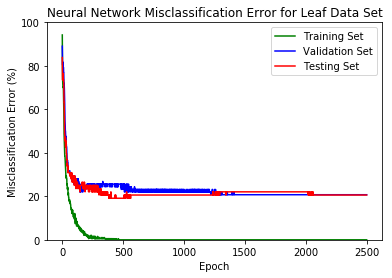

Training Set Misclassification Error is [0.0625]
Testing Set Misclassification Error is [0.20588235294117652]


In [75]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        logs['test_acc'] = acc


    
train_all = []
test_all = []

#values = random.sample(list(np.arange(0,len(trainX_S),1)),len(trainX_S))

trainX_use = trainX_S[values,:]
trainY_use = trainY[values,:]

model = Sequential()
model.add(Dense(250, input_dim=14, kernel_initializer='normal', activation='relu'))
model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint
filepath="weights.best_leaf.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [checkpoint, TestCallback((testX_S,testY)),CSVLogger('1.log')]
hist = model.fit(trainX_use[:-82,:],trainY_use[:-82,:], validation_data=(trainX_use[-82:,:],trainY_use[-82:,:]), nb_epoch=2500, batch_size=40,verbose=0,callbacks=callbacks_list)
plt.plot(100*np.array(1-np.array(hist.history['acc'])),'g')
plt.plot(100*np.array(1-np.array(hist.history['val_acc'])),'b')
plt.plot(100*np.array(1-np.array(hist.history['test_acc'])),'r')
plt.title('Neural Network Misclassification Error for Leaf Data Set')
plt.ylabel('Misclassification Error (%)')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Validation Set', 'Testing Set'])
plt.ylim([0,100])
plt.show()

train_pred_NN = convert_out(model.predict(trainX_use))
train_all.append(1-Pred_correct(train_pred_NN,trainY_comp_use))

test_pred_NN = convert_out(model.predict(testX_S))
test_all.append(1-Pred_correct(test_pred_NN,testY_comp))

print('Training Set Misclassification Error is', train_all)
print('Testing Set Misclassification Error is', test_all)    
                            

In [77]:
model1 = Sequential()
model1.add(Dense(250, input_dim=14, kernel_initializer='normal', activation='relu'))
model1.add(Dense(36, kernel_initializer='normal', activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.load_weights("weights.best_leaf.h5")



train_pred = convert_out(model1.predict(trainX_use[:-82]))
train_act = trainY_comp_use[:-82]
train_acc_1= (1-Pred_correct(train_pred,train_act))

val_pred = convert_out(model1.predict(trainX_use[-82:]))
val_act = trainY_comp_use[-82:]
val_acc_1 = (1-Pred_correct(val_pred,val_act))

test_pred = convert_out(model1.predict(testX_S))
test_acc_1 = (1-Pred_correct(test_pred,testY_comp))

results1 = pd.DataFrame(data = np.transpose([np.array(train_acc_1)*100,np.array(val_acc_1)*100,np.array(test_acc_1)*100]))
print(results1)


           0
0   0.000000
1  20.731707
2  20.588235


# Random Projections

In [ ]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
    def on_epoch_end(self, epoch, logs):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        logs['test_acc'] = acc

comp_to_check = 14
rp_sp = np.zeros((comp_to_check-2,2))

train_all = []
test_all = []
train_acc_rp = []
val_acc_rp = []
test_acc_rp = []


for i in range(2,comp_to_check+1):
    print(i)
    proj = GaussianRandomProjection(n_components=i)
    rp1 = proj.fit(trainX_S)
    rp_ = proj.transform(trainX_S)
    
    trainX_transformed = proj.transform(trainX_S)
    testX_transformed = proj.transform(testX_S)
    
    randMat = proj.components_
    X_Proj = rp_.dot(randMat)
    rp_sp[i-2,:] = [i,((X_Proj - trainX_scaled)**2).mean()]

    trainX_S_use = trainX_transformed[:,:i]
    testX_S_use = testX_transformed[:,:i]
    
    trainX_use = trainX_S_use[values,:]
    trainY_use = trainY[values,:]
    trainY_comp_use = trainY_comp[values]

    

    model = Sequential()
    model.add(Dense(250, input_dim=i, kernel_initializer='normal', activation='relu'))
    model.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # checkpoint
    filepath="weights.best_leaf.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    callbacks_list = [checkpoint, TestCallback((testX_S_use,testY)),CSVLogger('1.log')]
    hist = model.fit(trainX_use[:-82,:],trainY_use[:-82,:], validation_data=(trainX_use[-82:,:],trainY_use[-82:,:]), nb_epoch=2500, batch_size=40,verbose=0,callbacks=callbacks_list)
    
    model1 = Sequential()
    model1.add(Dense(250, input_dim=i, kernel_initializer='normal', activation='relu'))
    model1.add(Dense(36, kernel_initializer='normal', activation='softmax'))
    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model1.load_weights("weights.best_leaf.h5")


    train_pred = convert_out(model1.predict(trainX_use[:-82,:]))
    train_act = trainY_comp_use[:-82]
    train_acc_rp.append((1-Pred_correct(train_pred,train_act)))

    val_pred = convert_out(model1.predict(trainX_use[-82:,:]))
    val_act = trainY_comp_use[-82:]
    val_acc_rp.append((1-Pred_correct(val_pred,val_act)))

    test_pred = convert_out(model1.predict(testX_S_use))
    test_acc_rp.append((1-Pred_correct(test_pred,testY_comp)))

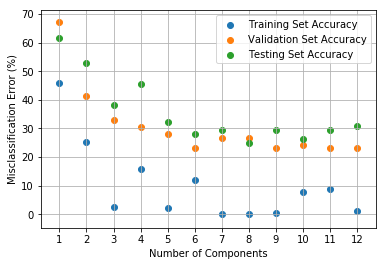

            0          1          2
0   45.789474  67.073171  61.764706
1   25.263158  41.463415  52.941176
2    2.631579  32.926829  38.235294
3   15.789474  30.487805  45.588235
4    2.105263  28.048780  32.352941
5   12.105263  23.170732  27.941176
6    0.000000  26.829268  29.411765
7    0.000000  26.829268  25.000000
8    0.526316  23.170732  29.411765
9    7.894737  24.390244  26.470588
10   8.947368  23.170732  29.411765
11   1.052632  23.170732  30.882353


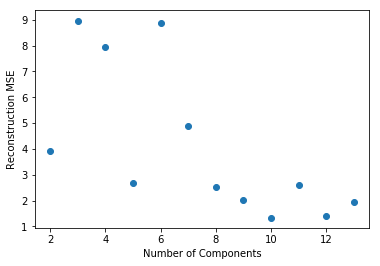

In [85]:
fig = plt.figure()
ax = fig.gca()
ax.set_yticks(np.arange(0, 100, 10))
ax.set_xticks(np.arange(1,len(train_acc)+1))

plt.scatter(np.arange(1,len(train_acc_rp)+1),np.array(train_acc_rp)*100,label='Training Set Accuracy')
plt.scatter(np.arange(1,len(train_acc_rp)+1),np.array(val_acc_rp)*100,label='Validation Set Accuracy')
plt.scatter(np.arange(1,len(train_acc_rp)+1),np.array(test_acc_rp)*100,label='Testing Set Accuracy')
plt.xlabel('Number of Components')
plt.ylabel('Misclassification Error (%)')
plt.legend()
plt.grid(True)
plt.show()

results = pd.DataFrame(data = np.transpose([np.array(train_acc_rp)*100,np.array(val_acc_rp)*100,np.array(test_acc_rp)*100]))
print(results)

plt.scatter(rp_sp[:,0],rp_sp[:,1])
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction MSE')
plt.show()